# Statistiques sur les jours couverts et de sol nu

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'capsat'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import yaml

from sqlalchemy import create_engine, text
from sqlalchemy.event import listen

import numpy as np
import pandas as pd
import math
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

from capsat.dbutils import load_spatialite, load_stat_aggregates

In [2]:
parameters_file = os.path.join('..', 'etc', 'parameters.yml')
with open(parameters_file, 'r') as f:
    params = yaml.safe_load(f)
lpis_database = params['parameters']['lpis_database']
lpis_table = params['parameters']['lpis_table']
lpis_id = params['parameters']['lpis_id']

engine = create_engine(f"sqlite:///{lpis_database}")
listen(engine, 'connect', load_spatialite)
listen(engine, 'connect', load_stat_aggregates)

## Statistiques sur toute l'année, tous codes

In [3]:
sql = text(f"""
    SELECT 
        lpis_id,
        code,
        covered_tr1 + covered_tr2 + covered_tr3 + covered_tr4 AS covered,
        bare_tr1 + bare_tr2 + bare_tr3 + bare_tr4 AS bare
    FROM coverage
""")
df = pd.read_sql(sql, engine, index_col="lpis_id")

In [4]:
dfg = df.groupby("code")
mean = dfg.mean()
mean.sort_values('covered', ascending=False, inplace=True)
std = dfg.std()
std.rename(columns={'covered': 'std'}, inplace=True)
mean = mean.join(std['std'])
median = dfg.median()

Text(0.5, 1.0, 'Moyenne sol couvert/sol nu entre le 1/11/2018 et le 31/10/2019')

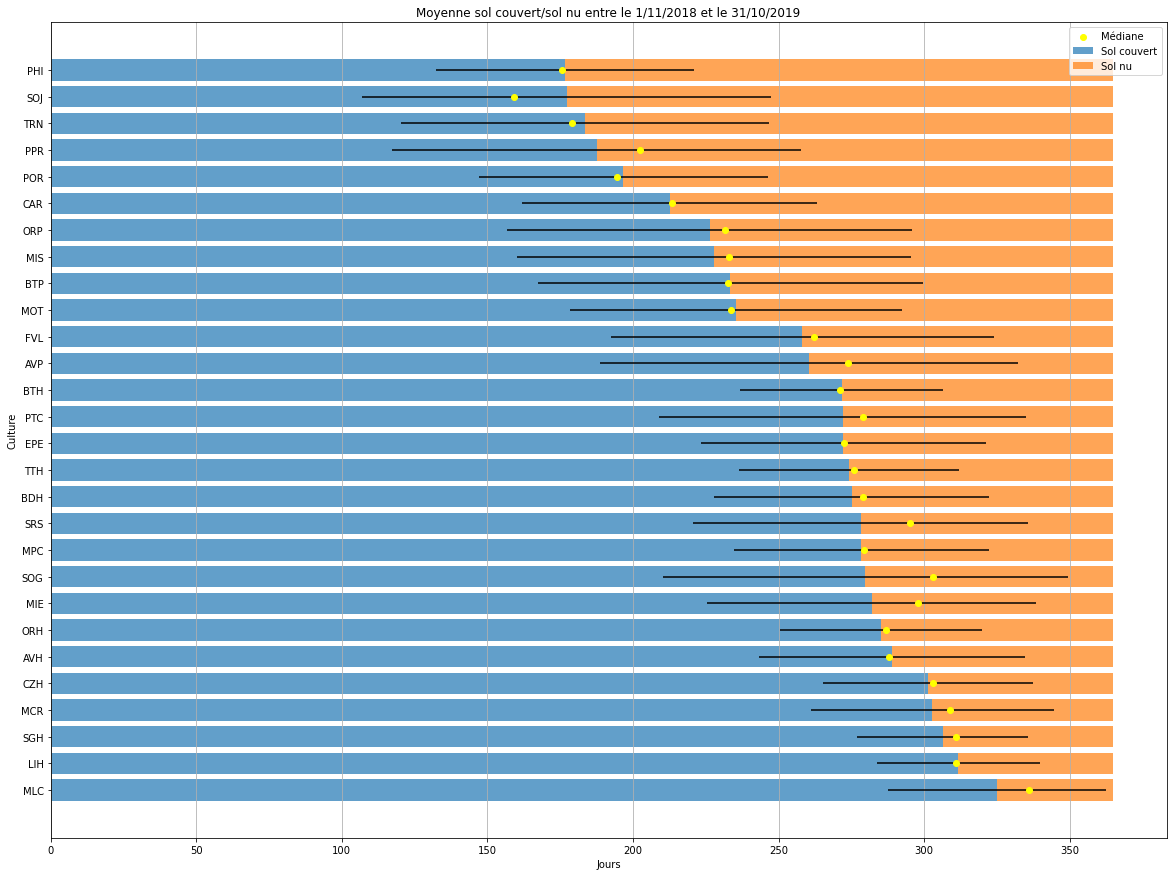

In [5]:
fig, ax = plt.subplots(1, figsize=(20, 15))
ax.barh(mean.index, mean['covered'], xerr=mean['std'], label="Sol couvert", alpha=0.7)
ax.barh(mean.index, mean['bare'], left=mean['covered'], label="Sol nu", alpha=0.7)
ax.scatter(median['covered'], median.index, color='yellow', label="Médiane", zorder=10)
ax.legend()
ax.grid(axis="x")
ax.set_xlabel("Jours")
ax.set_ylabel("Culture")
ax.set_title("Moyenne sol couvert/sol nu entre le 1/11/2018 et le 31/10/2019")

## Statistiques par code et par trimestre

In [6]:
code = 'MIS'
sql = text(f"""
    SELECT lpis_id, covered_tr1 AS tr1, covered_tr2 AS tr2, covered_tr3 AS tr3, covered_tr4 AS tr4
    FROM coverage
    WHERE code = :code
""")
covered = pd.read_sql(sql, engine, params={'code': code}, index_col="lpis_id")

sql = text(f"""
    SELECT lpis_id, bare_tr1 AS tr1, bare_tr2 AS tr2, bare_tr3 AS tr3, bare_tr4 AS tr4
    FROM coverage
    WHERE code = :code
""")
bare = pd.read_sql(sql, engine, params={'code': code}, index_col="lpis_id")

In [7]:
mean = pd.concat([covered.mean(), bare.mean()], axis=1)
std = pd.concat([covered.std(), bare.std()], axis=1)
median = pd.concat([covered.median(), bare.median()], axis=1)

Text(0.5, 1.0, 'Jours couverts et nus par trimestre (code MIS)')

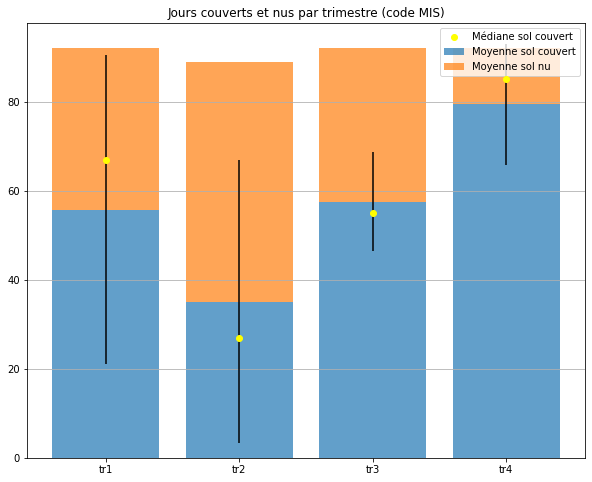

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(mean.index, mean[0], yerr=std[0], label="Moyenne sol couvert", alpha=0.7)
ax.bar(mean.index, mean[1], bottom=mean[0], label="Moyenne sol nu", alpha=0.7)
ax.scatter(median.index, median[0], color="yellow", label="Médiane sol couvert", zorder=10)

ax.grid(axis="y")
ax.legend()
ax.set_title(f"Jours couverts et nus par trimestre (code {code})")

## Probabilité de couverture

In [9]:
sql = text(f"""
    SELECT * FROM coverage_probability
""")
proba = pd.read_sql(sql, engine, parse_dates=['date'], index_col='date')

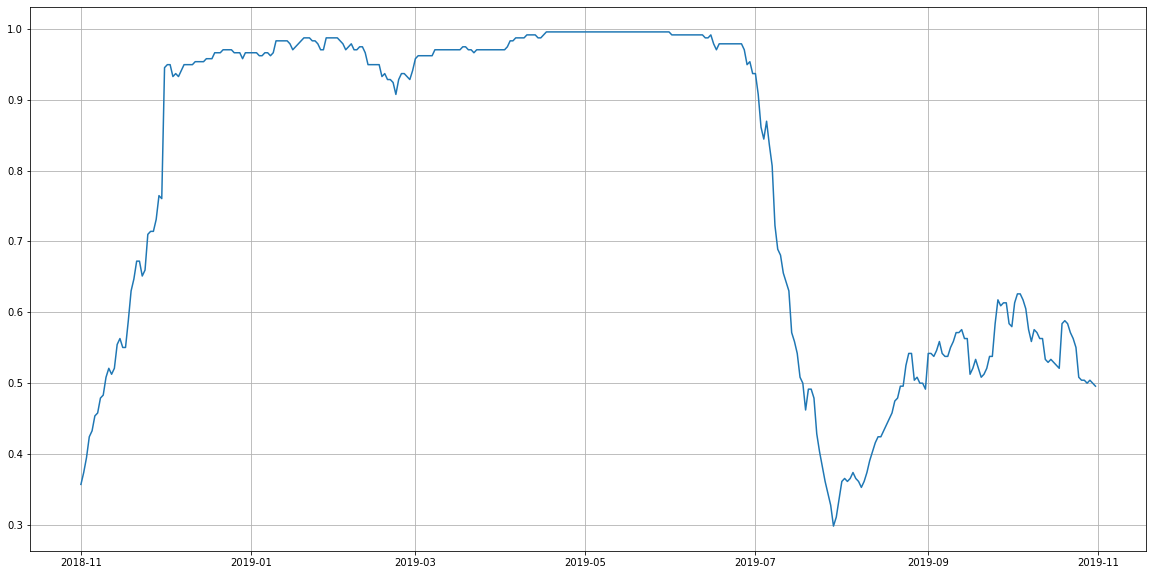

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(proba['AVH'], label=code)
ax.grid()